<a href="https://colab.research.google.com/github/ikram9820/Fastdl_v3-v5/blob/main/dl2%20v5/stablediffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq diffusers transformers fastcore


     |████████████████████████████████| 255 kB 16.1 MB/s 
     |████████████████████████████████| 5.3 MB 42.3 MB/s 
     |████████████████████████████████| 163 kB 58.0 MB/s 
     |████████████████████████████████| 7.6 MB 61.3 MB/s 


In [37]:

from PIL import Image
from fastcore.all import concat
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display 
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from pathlib import Path
import matplotlib.pyplot as plt
import torch, logging
import torchvision.transforms as tfms


In [38]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:

logging.disable(logging.WARNING)
notebook_login()


Login successful
Your token has been saved to /root/.huggingface/token


In [39]:

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14',torch_dtype = torch.float16)
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14',torch_dtype = torch.float16).to(torch_device)
vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema', torch_dtype = torch.float16).to(torch_device)
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet', torch_dtype=torch.float16).to(torch_device)

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)


In [40]:

prompts = [
    'a photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]
height = 512
width = 512


In [41]:
# prompt = 'A picture of a puppy'

# text_encoder

# # Tokenize
# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# input_ids = text_input.input_ids.to(torch_device)

# # Get token embeddings
# token_embeddings = token_emb_layer(input_ids)

# # The new embedding. Which is now a mixture of the token embeddings for 'puppy' and 'skunk'
# puppy_token_embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
# skunk_token_embedding = token_emb_layer(torch.tensor(42194, device=torch_device))
# replacement_token_embedding = 0.5*puppy_token_embedding + 0.5*skunk_token_embedding

# # Insert this into the token embeddings (
# token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# # Combine with pos embs
# input_embeddings = token_embeddings + position_embeddings

# #  Feed through to get final output embs
# modified_output_embeddings = get_output_embeds(input_embeddings)

# # Generate an image with these
# generate_with_embs(modified_output_embeddings)

In [42]:

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(torch_device))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))


In [43]:

def mk_samples(prompts, text_emb=None, encoded=None, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    if not text_emb:
      text_emb = text_enc(prompts)
    text_emb = text_emb
    uncond = text_enc([""] * bs, text_emb.shape[1])
    emb = torch.cat([uncond, text_emb])
    if seed: torch.manual_seed(seed)

    if encoded:
      start_step = 10
      start_sigma = scheduler.sigmas[start_step]
      noise = torch.randn_like(encoded)
      latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
      latents = latents.to(torch_device).float()

    else:
      latents = torch.randn((bs, unet.in_channels, height//8, width//8))
      scheduler.set_timesteps(steps)
      latents = latents.to(torch_device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
      if (not encoded) or (i>start_step):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample


In [ ]:
! pip install duckduckgo_search

In [45]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

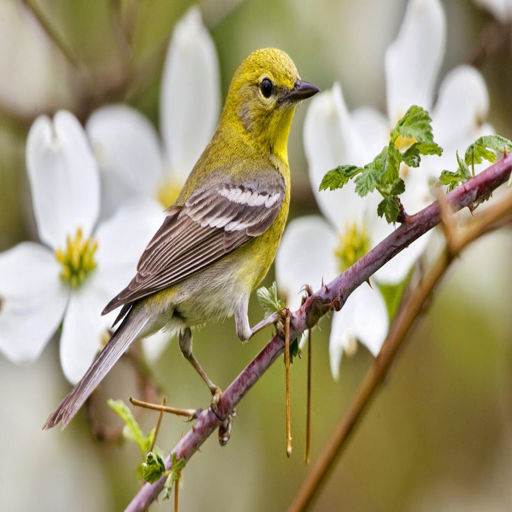

In [46]:
dest = 'bird.jpg'
urls = search_images('high resolutionbird photo',2)
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest).resize((512,512))
im

In [47]:
latent = pil_to_latent(im)
latent.shape

RuntimeError: ignored

In [ ]:

images = mk_samples(prompts)

display(mk_img(images[0]))